In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMakerPlus import *

In [3]:
GB_LIMIT = 30

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [5]:
IMAGE_SHAPE = (5, 64, 64)
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [6]:
TRAIN_PATH = f'/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_training.hdf5'
VAL_PATH = f'/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_validation.hdf5'
TEST_PATH = f'/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_testing.hdf5'

In [7]:
args_gen = {
    'scaler': True,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

In [8]:
train_images = HDF5DataGenerator(src=TRAIN_PATH, label_key='image', **args_gen)
val_images = HDF5DataGenerator(src=VAL_PATH, label_key='image', **args_gen)
test_images = HDF5DataGenerator(src=TEST_PATH, label_key='image', **args_gen)

train_g = HDF5DataGenerator(src=TRAIN_PATH, label_key='g_cmodel_mag', **args_gen)
val_g = HDF5DataGenerator(src=VAL_PATH, label_key='g_cmodel_mag', **args_gen)
test_g = HDF5DataGenerator(src=TEST_PATH, label_key='g_cmodel_mag', **args_gen)

train_r = HDF5DataGenerator(src=TRAIN_PATH, label_key='r_cmodel_mag', **args_gen)
val_r = HDF5DataGenerator(src=VAL_PATH, label_key='r_cmodel_mag', **args_gen)
test_r = HDF5DataGenerator(src=TEST_PATH, label_key='r_cmodel_mag', **args_gen)

train_i = HDF5DataGenerator(src=TRAIN_PATH, label_key='i_cmodel_mag', **args_gen)
val_i = HDF5DataGenerator(src=VAL_PATH, label_key='i_cmodel_mag', **args_gen)
test_i = HDF5DataGenerator(src=TEST_PATH, label_key='i_cmodel_mag', **args_gen)

train_z = HDF5DataGenerator(src=TRAIN_PATH, label_key='z_cmodel_mag', **args_gen)
val_z = HDF5DataGenerator(src=VAL_PATH, label_key='z_cmodel_mag', **args_gen)
test_z = HDF5DataGenerator(src=TEST_PATH, label_key='z_cmodel_mag', **args_gen)

train_y = HDF5DataGenerator(src=TRAIN_PATH, label_key='y_cmodel_mag', **args_gen)
val_y = HDF5DataGenerator(src=VAL_PATH, label_key='y_cmodel_mag', **args_gen)
test_y = HDF5DataGenerator(src=TEST_PATH, label_key='y_cmodel_mag', **args_gen)

train_specz = HDF5DataGenerator(src=TRAIN_PATH, label_key='specz_redshift', **args_gen)
val_specz = HDF5DataGenerator(src=VAL_PATH, label_key='specz_redshift', **args_gen)
test_specz = HDF5DataGenerator(src=TEST_PATH, label_key='specz_redshift', **args_gen)

TypeError: HDF5DataGenerator.__init__() got an unexpected keyword argument 'label_key'

In [8]:
train_mags = JoinedMags(train_g, train_r, train_i, train_z, train_y)
val_mags = JoinedMags(val_g, val_r, val_i, val_z, val_y)
test_mags = JoinedMags(test_g, test_r, test_i, test_z, test_y)

In [9]:
train_gen = JoinedGen(train_images, train_mags, train_specz)
val_gen = JoinedGen(val_images, val_mags, val_specz)
test_gen = JoinedGen(test_images, test_mags, test_specz)

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_cnn = Input(shape=(5,127,127))
input_nn = Input(shape=(5,))

# CNN
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = Flatten()(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

# NN
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)
hidden5 = Dense(hparams['num_dense_units'], activation="relu")(hidden4)
hidden6 = Dense(hparams['num_dense_units'], activation="relu")(hidden5)

# Concat & Output
concat = Concatenate()([dense3, hidden6])
output = Dense(1)(concat)
model = Model(inputs=[input_cnn, input_nn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 127, 127  1472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 63, 63)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_combined_with_5pool_v15'

checkpoint_filepath = f'/data2/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/data2/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(train_gen, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=val_gen, callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/100
784/784 [==============================] - ETA: 0s - loss: 0.2358 - mse: 0.2076

2023-05-15 18:23:26.556898: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2023-05-15 18:23:26.666118: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.



Epoch 1: loss improved from inf to 0.23582, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 990s 1s/step - loss: 0.2358 - mse: 0.2076 - val_loss: 0.2037 - val_mse: 0.1183
Epoch 2/100
784/784 [==============================] - ETA: 0s - loss: 0.1464 - mse: 0.0974

2023-05-15 18:37:08.079251: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.
2023-05-15 18:37:08.230156: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.



Epoch 2: loss improved from 0.23582 to 0.14639, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 822s 1s/step - loss: 0.1464 - mse: 0.0974 - val_loss: 0.1176 - val_mse: 0.0956
Epoch 3/100
784/784 [==============================] - ETA: 0s - loss: 0.1164 - mse: 0.0854

2023-05-15 18:53:12.931371: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 566231040 exceeds 10% of free system memory.



Epoch 3: loss improved from 0.14639 to 0.11638, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 965s 1s/step - loss: 0.1164 - mse: 0.0854 - val_loss: 0.1180 - val_mse: 0.0907
Epoch 4/100
784/784 [==============================] - ETA: 0s - loss: 0.0982 - mse: 0.0782
Epoch 4: loss improved from 0.11638 to 0.09816, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 547s 698ms/step - loss: 0.0982 - mse: 0.0782 - val_loss: 0.0916 - val_mse: 0.0790
Epoch 5/100
784/784 [==============================] - ETA: 0s - loss: 0.0804 - mse: 0.0693
Epoch 6: loss improved from 0.08465 to 0.08039, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 500s 638ms/step - loss: 0.0804 - mse: 0.0693 - val_loss: 0.0846 - val_mse: 0.0691
Epoch 7/100
784/784 [==

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - ETA: 0s - loss: 0.0357 - mse: 0.0383
Epoch 20: loss improved from 0.03614 to 0.03569, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 478s 610ms/step - loss: 0.0357 - mse: 0.0383 - val_loss: 0.0662 - val_mse: 0.0578
Epoch 21/100
784/784 [==============================] - ETA: 0s - loss: 0.0353 - mse: 0.0379
Epoch 21: loss improved from 0.03569 to 0.03532, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 475s 606ms/step - loss: 0.0353 - mse: 0.0379 - val_loss: 0.0596 - val_mse: 0.0535
Epoch 22/100
784/784 [==============================] - ETA: 0s - loss: 0.0321 - mse: 0.0370
Epoch 22: loss improved from 0.03532 to 0.03214, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v15/checkpoints/cp.ckpt
784/784 [==============================] - 552s 705ms/step - 

In [16]:
model.load_weights(checkpoint_filepath)

In [17]:
pred = model.predict(test_gen)

168/168 [==============================] - 75s 445ms/step


In [18]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    oid_test = np.asarray(file['object_id'][:])

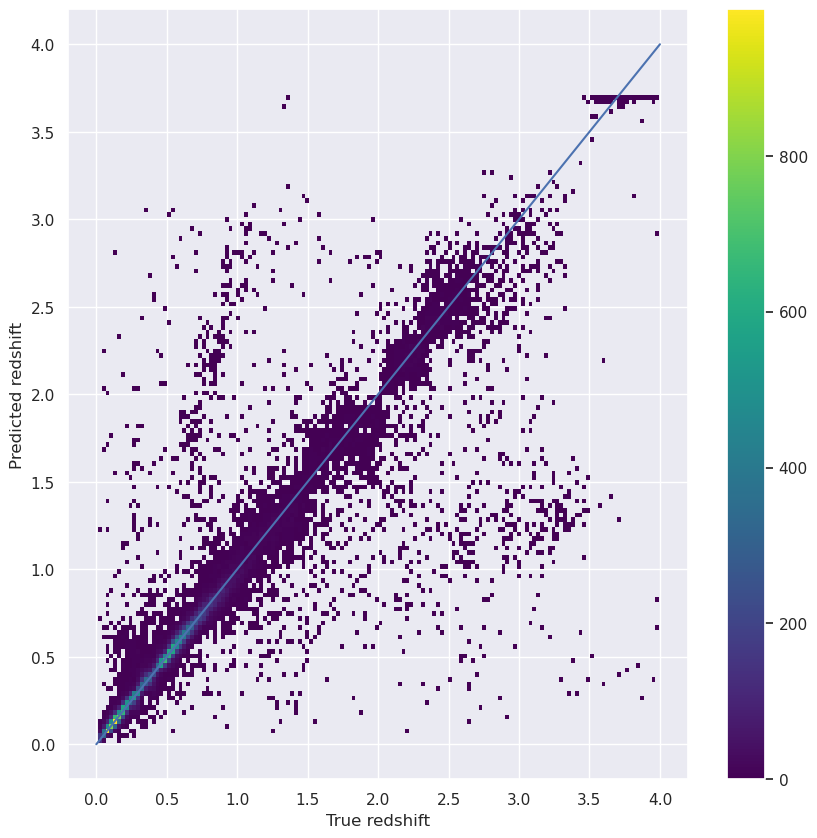

In [19]:
plot_predictions(np.ravel(pred), y_test)

In [20]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [21]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.057983,0.001557,0.001757,0.022596,0.019766,0.125652,0.035801,0.052974


In [22]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)